In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('spark') \
    .getOrCreate()

In [2]:
## 1. OTs GS

ot_gs = spark.read.json('/Users/irene/Documents/dev/l2g_gs/data/gwas_gold_standards.191108.jsonl')

In [3]:
print(ot_gs.first())
#ot_gs.printSchema()

Row(association_info=Row(ancestry=['EUR'], doi=None, gwas_catalog_id='GCST000324', neg_log_pval=23.699, otg_id='GCST000324_3', pubmed_id='19185284', url=None), gold_standard_info=Row(evidence=[Row(class='expert curated', confidence='High', curated_by='Eric Fauman', description='BCO1 (previously referred to as BCMO1) encodes beta-carotene oxygenase 1 which uses a molecule of oxygen to produce two molecules of retinol from beta-carotene.  Enzyme deficiency results in accumulation of beta-carotene.', pubmed_id='11401432', source=None)], gene_id='ENSG00000135697', highest_confidence='High'), metadata=Row(comments=None, date_added='2019-05-17', reviewed_by='Ed Mountjoy', set_label='ProGeM', submitted_by='Eric Fauman', tags=['metabolite', 'mQTL']), sentinel_variant=Row(alleles=Row(alternative='G', reference='T'), locus_GRCh37=Row(chromosome='16', position=81264597), locus_GRCh38=Row(chromosome='16', position=81230992), rsid='rs6564851'), trait_info=Row(ontology=['HMDB0000561'], reported_trai

In [4]:
# Provenances of the assoc
print(ot_gs.select('metadata.tags').distinct().show(truncate=False))

#print(ot_gs.filter(F.col('metadata.tags').isNull()).first())

+---------------------------------+
|tags                             |
+---------------------------------+
|[drug, ChEMBL, ChEMBL_III]       |
|null                             |
|[metabolite, mQTL]               |
|[drug, ChEMBL, ChEMBL_II]        |
|[T2D]                            |
|[Fauman, Biological plausability]|
|[drug, ChEMBL, ChEMBL_IV]        |
+---------------------------------+

None


In [5]:
ot_gs = (ot_gs
 .filter(F.col('gold_standard_info.highest_confidence').isin(['High', 'Medium']))
 # Extract gene/trait pairs
 .withColumn('trait_id', F.explode('trait_info.ontology'))
 .select('gold_standard_info.gene_id', 'trait_id')
 .distinct()
)

# 619 pairs in the OT's GS with a high, medium confidence

In [6]:
## 1.2. Expand ontology

disease_idx = (
    spark.read.parquet('/Users/irene/Documents/dev/pyspark/21.11.2/diseases')
    .select(F.array(F.col('id')).alias('id'), 'ancestors')
    .withColumn('ids', F.array_union(F.col('id'), F.col('ancestors')))
    .withColumn('id', F.explode('id'))
    .select('id', 'ids')
)

disease_idx.first()

Row(id='GO_0044238', ids=['GO_0044238', 'GO_0008152', 'GO_0008150'])

In [7]:
ot_gs_expanded = (
    ot_gs.join(disease_idx, disease_idx['id'] == ot_gs['trait_id'], how='left')
    .withColumn('trait_id', F.coalesce('ids', F.array(F.col('trait_id'))))
    .withColumn('trait_id', F.explode('trait_id'))
    .select('gene_id', 'trait_id')
    .distinct()
    .persist()
)

ot_gs_expanded.show()

+---------------+---------------+
|        gene_id|       trait_id|
+---------------+---------------+
|ENSG00000198721|    HMDB0013205|
|ENSG00000107611|    HMDB0002174|
|ENSG00000258947|    EFO_0000707|
|ENSG00000115380|    EFO_0000618|
|ENSG00000145777|    EFO_0009433|
|ENSG00000154122|  MONDO_0001933|
|ENSG00000134243|    EFO_0004732|
|ENSG00000100344|    EFO_0010284|
|ENSG00000157978|    EFO_0001444|
|ENSG00000122691|     HP_0011025|
|ENSG00000088832|   OTAR_0000020|
|ENSG00000100985|    EFO_0006858|
|ENSG00000257923|   OTAR_0000010|
|ENSG00000015520|    EFO_0004611|
|ENSG00000093217|    HMDB0000115|
|ENSG00000113302|Orphanet_158300|
|ENSG00000258947|  MONDO_0000653|
|ENSG00000134827|    EFO_0001069|
|ENSG00000113580|  MONDO_0007263|
|ENSG00000171094|    EFO_0000311|
+---------------+---------------+
only showing top 20 rows



In [8]:
ot_gs_expanded.count()

3416

In [13]:
## 2. Eric's GS

file = '/Users/irene/Documents/dev/l2g_gs/data/manual_gene_to_trait_rules.xlsx'

eric_gs = spark.createDataFrame(pd.read_excel(file, sheet_name='Sheet1').astype(str))
eric_gs.first()

Row(type='metQTL', assertion_source='Fauman metabolites', published='yes', gene='A4GALT', trait='HMDB0011594|HMDB0011595', confidence='1000', why='A4GALT encodes a lactosylceramide 4-alpha-galactosyltransferase which adds a galactose moeity to a lactosylceramide molecule resulting in  globotriaosylceramide\xa0(Gb3). The observed metabolite is a likely substrate.', source='10748143')

In [15]:
import plotly.express as px

fig = px.pie(eric_gs.toPandas(), names='type', title="Eric's new dataset per data type")
fig.show()

In [16]:
fig2 = px.pie(eric_gs.toPandas(), names='assertion_source', title="Eric's new dataset per source")
fig2.show()

In [10]:
eric_gs = (
    
    eric_gs.filter(F.col('gene').isNotNull())
    
    .filter(F.col('confidence') == '1000')
    
    # some metabolites are mapped to a less specific term.
    # That is indicated with a "~" before the ID (~HMDB0008047).
    # I take those mappings are valid and remove the '~'
    .withColumn('trait_id', F.translate('trait', '~+', ''))
    
    # Multiple gene/disease traits are divided by '|'
    .withColumn('trait_id', F.explode(F.split(F.col('trait_id'), '\|')))
    .withColumn('gene', F.explode(F.split(F.col('gene'), '\|')))
    
    .select('trait_id', 'gene').distinct()
)

eric_gs.show()

+-----------+-----+
|   trait_id| gene|
+-----------+-----+
|HMDB0001438|  ABO|
|HMDB0001291|ACADM|
|HMDB0011738|ACADM|
|     CXCL11|ACKR1|
|HMDB0000625| ADH6|
|HMDB0007973|APOA4|
|HMDB0000625| ADH7|
|EFO_1001931| ADH6|
|HMDB0010169|APOC3|
|HMDB0049769|APOA1|
|HMDB0001043|APOA1|
|EFO_0000249| APOE|
|HMDB0013240|ACSM5|
|HMDB0010169|APOC4|
|HMDB0000054|ABCG8|
|EFO_0003829| ADH7|
|EFO_1001931|ADH1C|
|HMDB0001043| APOE|
|HMDB0013128|ACADS|
|      CXCL5|ACKR1|
+-----------+-----+
only showing top 20 rows



In [ ]:
eric_gs

In [11]:
## 2.1. Map gene to Ensembl

target_idx = (
    spark.read.parquet('/Users/irene/Documents/dev/pyspark/21.11.2/targets')
    .select(F.col('id').alias('gene_id'), F.col('approvedSymbol').alias('gene'))
)
target_idx.first()

Row(gene_id='ENSG00000002016', gene='RAD52')

In [12]:
# All genes except one (813/814) are mappable using the approved symbol 

eric_gs = eric_gs.join(target_idx, on='gene', how='left')
eric_gs.show()

+-----+-----------+---------------+
| gene|   trait_id|        gene_id|
+-----+-----------+---------------+
|  ABO|HMDB0001438|ENSG00000175164|
|ACADM|HMDB0001291|ENSG00000117054|
|ACADM|HMDB0011738|ENSG00000117054|
|ACKR1|     CXCL11|ENSG00000213088|
| ADH6|HMDB0000625|ENSG00000172955|
|APOA4|HMDB0007973|ENSG00000110244|
| ADH7|HMDB0000625|ENSG00000196344|
| ADH6|EFO_1001931|ENSG00000172955|
|APOC3|HMDB0010169|ENSG00000110245|
|APOA1|HMDB0049769|ENSG00000118137|
|APOA1|HMDB0001043|ENSG00000118137|
| APOE|EFO_0000249|ENSG00000130203|
|ACSM5|HMDB0013240|ENSG00000183549|
|APOC4|HMDB0010169|ENSG00000267467|
|ABCG8|HMDB0000054|ENSG00000143921|
| ADH7|EFO_0003829|ENSG00000196344|
|ADH1C|EFO_1001931|ENSG00000248144|
| APOE|HMDB0001043|ENSG00000130203|
|ACADS|HMDB0013128|ENSG00000122971|
|ACKR1|      CXCL5|ENSG00000213088|
+-----+-----------+---------------+
only showing top 20 rows



In [12]:
# I am not performing the ontology expansion on Eric's dataset to preserve his curations as such
# The datasets will still be comparable as the difference in granularity will be addressed in the dataset I am comparing with
'''
## 2.2 Expand ontology

eric_gs_expanded = (
    eric_gs.join(diseases, diseases['id'] == eric_gs['trait_id'], how='left')
    .withColumn('disease_id', F.coalesce('ids', F.array(F.col('trait_id'))))
    .withColumn('disease_id', F.explode('disease_id'))
    .select('gene_id', 'disease_id')
    .distinct()
    .persist()
)

eric_gs_expanded.show()

'''

"\n## 2.2 Expand ontology\n\neric_gs_expanded = (\n    eric_gs.join(diseases, diseases['id'] == eric_gs['trait_id'], how='left')\n    .withColumn('disease_id', F.coalesce('ids', F.array(F.col('trait_id'))))\n    .withColumn('disease_id', F.explode('disease_id'))\n    .select('gene_id', 'disease_id')\n    .distinct()\n    .persist()\n)\n\neric_gs_expanded.show()\n\n"

In [13]:
# Many of Eric's annotation concerns metabolite measurements.
# I want to also compare the datasets without including these as traits.

eric_gs_without_metabolites = eric_gs.filter(~F.col('trait_id').contains('HMDB'))

print(f"Eric's dataset with metabolites: {eric_gs.count()} pairs")
print(f"Eric's dataset with metabolites: {eric_gs_without_metabolites.count()} pairs")

Eric's dataset with metabolites: 3665 pairs
Eric's dataset with metabolites: 1481 pairs


## Questions

### 1. What is the overlap between GSs?

In [14]:

overlap = eric_gs.join(ot_gs, on=['trait_id', 'gene_id'], how='inner')
overlap_w_expansion = eric_gs.join(ot_gs_expanded, on=['trait_id', 'gene_id'], how='inner')
overlap_w_expansion_without_metabolites = eric_gs_without_metabolites.join(ot_gs_expanded, on=['trait_id', 'gene_id'], how='inner')

print('Assocs without expansion: ', overlap.count(), f'({overlap.count()/eric_gs.count():.3f})')
print('Assocs with expansion: ', overlap_w_expansion.count(), f'({overlap_w_expansion.count()/eric_gs.count():.3f})')
print('Assocs with expansion without metabolites: ', overlap_w_expansion_without_metabolites.count(), f'({overlap_w_expansion_without_metabolites.count()/eric_gs_without_metabolites.count():.3f})')

Assocs without expansion:  298 (0.081)
Assocs with expansion:  328 (0.089)
Assocs with expansion without metabolites:  146 (0.099)


### 1.2 Follow-up question: Is original Eric's contribution to the L2G GS in the newer GS?
We should be expecting to see all of his contributions in his more extended dataset.

In [15]:
ot_gs_contributed_by_eric = (
    spark.read.json('/Users/irene/Documents/dev/l2g_gs/data/gwas_gold_standards.191108.jsonl')

    .filter(F.col('gold_standard_info.highest_confidence').isin(['High', 'Medium']))
    # Extract gene/trait pairs
    .withColumn('trait_id', F.explode('trait_info.ontology'))

    # Filter by assertions either submitted by Eric or which are part of the T2D Database (initiated by him)
    .filter(
        (F.col('metadata.set_label').contains('T2D'))
        | (F.col('metadata.submitted_by').contains('Fauman'))
    )

    .select(F.col('gold_standard_info.gene_id').alias('gene_id'), 'trait_id')
    .distinct()
)

print(f'Eric Fauman has been somehow involved in {ot_gs_contributed_by_eric.count()} ({ot_gs_contributed_by_eric.count()/ot_gs.count() * 100:.2f}%) of the L2G GS curation.')


Eric Fauman has been somehow involved in 385 (62.20%) of the L2G GS curation.


In [16]:
ot_gs_contributed_by_eric.join(eric_gs, on=['trait_id', 'gene_id'], how='inner').distinct().count()

280

In [24]:
tmp = ot_gs_contributed_by_eric.join(eric_gs, on=['trait_id', 'gene_id'], how='left_anti').distinct()

tmp.show()

+-------------+---------------+
|     trait_id|        gene_id|
+-------------+---------------+
|  EFO_0009589|ENSG00000179603|
|  HMDB0000168|ENSG00000162174|
|   HP_0002140|ENSG00000122691|
|  EFO_0004530|ENSG00000132855|
|  HMDB0061690|ENSG00000125505|
|  EFO_0009270|ENSG00000177150|
|  EFO_0008111|ENSG00000105550|
|  EFO_0004612|ENSG00000062282|
|  HMDB0060102|ENSG00000125505|
|    HMDB13130|ENSG00000105607|
|  EFO_0008111|ENSG00000115850|
|  HMDB0062556|ENSG00000140374|
|  EFO_0007985|ENSG00000101162|
|   HP_0012603|ENSG00000105550|
|  EFO_0000378|ENSG00000147889|
|  EFO_0009387|ENSG00000140470|
|MONDO_0000334|ENSG00000125798|
|  EFO_0000378|ENSG00000147883|
|  EFO_0004530|ENSG00000163956|
|  EFO_0008111|ENSG00000169208|
+-------------+---------------+
only showing top 20 rows



In [27]:
tmp2 = spark.read.json('/Users/irene/Documents/dev/l2g_gs/data/gwas_gold_standards.191108.jsonl').withColumn('trait_id', F.explode('trait_info.ontology')).withColumn('gene_id', F.col('gold_standard_info.gene_id')).join(tmp, on=['trait_id', 'gene_id'], how='inner')

In [28]:
tmp2.show(5, False, True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 trait_id           | HMDB0008031                                                                                                                                                                                                                                      
 gene_id            | ENSG00000204310                                                                                                                                                                                                                                  
 association_info   | {[EUR], null, GCST001414, 9.097, GCST001414_2, 22359512, null}                                                                                                                            

In [17]:
ot_gs_contributed_by_eric.join(eric_gs, on=['trait_id', 'gene_id'], how='left_anti').distinct().first()

Row(trait_id='EFO_0009589', gene_id='ENSG00000179603')

In [18]:
import matplotlib.pyplot as plt
from venn import venn

current_gs = set(ot_gs.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())
current_gs_submitted_by_eric = set(ot_gs_contributed_by_eric.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())
new_gs = set(eric_gs.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())
ot_clinvar = set(clinvar.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())

venn_sets = {
    #'ClinVar': ot_clinvar,
    'Erics new GS': new_gs,
    'Subset of Erics annotation from current L2G GS': current_gs_submitted_by_eric,
    'Current L2G GS': current_gs,
}

venn(venn_sets, legend_loc="best")

NameError: name 'clinvar' is not defined

### 2. Assess the value of this set as an evidence by seeing the overlap wth Clinvar.

In [138]:

clinvar = (
    spark.read.parquet('/Users/irene/Documents/dev/pyspark/21.09.5/associationByDatasourceIndirect')
    .filter(F.col('datasourceId') == 'eva')
    .select(
        F.col('targetId').alias('gene_id'),
        F.col('diseaseId').alias('trait_id'))
) 

clinvar.first()

Row(gene_id='ENSG00000085999', trait_id='EFO_0000574')

In [265]:
# Overlap with the expanded dataset as the assocs are indirect 

clinvar_overlap = eric_gs.join(clinvar, on=['trait_id', 'gene_id'], how='inner').distinct()

print('Erics assocs already in Clinvar: ', clinvar_overlap.count(), f'({clinvar_overlap.count()/eric_gs.count():.3f})')

Erics assocs already in Clinvar:  78 (0.021)


### 3. Assess the value of this set as an evidence by seeing the overlap with OT Platform.

In [135]:
# Clinvar only covers a small amount of the GS. Let's make the comparison with the all the sources

assocs = (
    spark.read.parquet('/Users/irene/Documents/dev/pyspark/21.11.2/associationByOverallIndirect')
    .select(
        F.col('targetId').alias('gene_id'),
        F.col('diseaseId').alias('trait_id'))
) 

ot_overlap = eric_gs.join(assocs, on=['trait_id', 'gene_id'], how='inner').distinct()

print('Erics assocs already in OT: ', ot_overlap.count(), f'({ot_overlap.count()/eric_gs.count():.3f})')

Erics assocs already in OT:  1065 (0.291)


In [267]:
# Are Eric's novelties compatible with the Platform?

eric_novel = eric_gs.join(assocs, on=['trait_id', 'gene_id'], how='left_anti').distinct()

eric_resolvable_assocs = eric_novel.join(disease_idx, eric_novel['trait_id'] == disease_idx['id'], how='inner').drop('id', 'ids').distinct()

print('Potential Erics novel associations: ', eric_novel.count())
print(f'... of which {eric_resolvable_assocs.count()} ({eric_resolvable_assocs.count()/eric_novel.count():.3f}) can be resolved to OTs entities')

Potential Erics novel associations:  2603
... of which 206 (0.079) can be resolved to OTs entities


In [269]:
# Where are the non resolvable diseases coming from?
eric_nonresolvable_traits = eric_novel.join(disease_idx, eric_novel['trait_id'] == disease_idx['id'], how='left_anti').select('trait_id').distinct()
print(f"{eric_nonresolvable_traits.filter(F.col('trait_id').startswith('HMDB')).count()} / {eric_nonresolvable_traits.count()} refer to metabolites (HMDB terms).")

711 / 770 refer to metabolites (HMDB terms).


### 4. Benchmark the locus2gene score

In [115]:
## 2. Benchmark the locus2gene score with the dataset
Likelihood of a gene is causal is to a certain trait.

24118

In [164]:
# Read the table with the inferred **causal gene** of a **variant** for a certain **study**

l2g_table = spark.read.parquet('/Users/irene/Documents/evidence_datasource_parsers/data/l2g')
l2g_table.first()

Row(study_id='NEALE2_21002_raw', chrom='5', pos=43190759, ref='T', alt='TA', gene_id='ENSG00000151881', training_clf='xgboost', training_gs='high_medium', training_fold='fold4=15|13|14|X|5|19', y_proba_dist_foot=0.01092243567109108, y_proba_dist_tss=0.3761053681373596, y_proba_full_model=0.010167195461690426, y_proba_logi_distance=0.012804814614355564, y_proba_logi_interaction=0.02010471560060978, y_proba_logi_molecularQTL=0.017179131507873535, y_proba_logi_pathogenicity=0.06014019250869751, y_proba_logo_distance=0.019822461530566216, y_proba_logo_interaction=0.010264221578836441, y_proba_logo_molecularQTL=0.008583013899624348, y_proba_logo_pathogenicity=0.009336715564131737)

In [181]:
l2g_table_processed = (
    
    l2g_table.withColumn('variant_id', F.concat('chrom', F.lit('_'), 'pos', F.lit('_'), 'ref', F.lit('_'), 'alt'))
    .withColumn('prediction', F.struct(F.col('gene_id').alias('gene_id'), F.col('y_proba_full_model').alias('proba')))
    
    .groupBy('variant_id', 'study_id')
    .agg(F.collect_set('prediction').alias('prediction'), F.max('y_proba_full_model').alias('max_proba'))
    
    # take gene_id with the greatest proba
    .withColumn('prediction', F.explode('prediction'))
    .filter(F.col('prediction.proba') == F.col('max_proba'))
    .withColumn('gene_id', F.col('prediction.gene_id'))
    
    # filter associations with a l2g score > .05
    .filter(F.col('max_proba') >= 0.05)
    
    .select('study_id', 'variant_id', 'gene_id', 'max_proba')
    .distinct()
)

l2g_table_processed.first()

Row(study_id='GCST90019505', variant_id='10_100006605_T_C', gene_id='ENSG00000107554', max_proba=0.8230782151222229)

In [182]:
# Extract associated trait for the study_id

study_idx = spark.read.json('/Users/irene/Documents/evidence_datasource_parsers/data/study-index').select('study_id', 'trait_efos')

l2g_table_processed_w_trait = (
    
    l2g_table_processed
    .join(study_idx, on='study_id', how='left')
    .withColumn('trait_id', F.explode('trait_efos'))
    
    .drop('trait_efos', 'study_id')
)

l2g_table_processed_w_trait.first()

Row(variant_id='10_100006605_T_C', gene_id='ENSG00000107554', max_proba=0.8230782151222229, trait_id='EFO_0004570')

In [183]:
# Ontology expansion to address diff granularities with Eric's GS

l2g_table_processed_w_trait_expanded = (
    
    l2g_table_processed_w_trait.join(disease_idx, disease_idx['id'] == l2g_table_processed_w_trait['trait_id'], how='left')
    .withColumn('trait_id', F.coalesce('ids', F.array(F.col('trait_id'))))
    .withColumn('trait_id', F.explode('trait_id'))
    .select(F.col('gene_id').alias('predicted_gene_id'), 'trait_id')
    .distinct()
    .persist()
    
)

l2g_table_processed_w_trait_expanded.count()

360431

In [184]:
# How well does l2g predictions perform against the GS?

benchmark = (
    eric_gs.join(l2g_table_processed_w_trait_expanded, on='trait_id', how='left')
    .withColumn(
        'exactMatch',
        F.when(F.col('gene_id') == F.col('predicted_gene_id'), True).otherwise(False)
    )
    .distinct()
)

benchmark.first()

Row(trait_id='EFO_0000292', gene='PSCA', gene_id='ENSG00000167653', predicted_gene_id='ENSG00000184378', exactMatch=False)

In [185]:
#benchmark.filter(F.col('exactMatch')).select('trait_id', 'gene_id').distinct().count()

print(f"{benchmark.filter(F.col('exactMatch')).select('trait_id', 'gene_id').distinct().count()} out of {benchmark.select('trait_id', 'gene_id').distinct().count()} Eric's gene/trait pairs overlap with those inferred from L2G.")

870 out of 3665 Eric's gene/trait pairs overlap with those inferred from L2G.


In [186]:
# Pretty badly. Let's do the same thing filtering the metabolite measurements out 

benchmark_without_metabolites = (
    eric_gs_without_metabolites.join(l2g_table_processed_w_trait_expanded, on='trait_id', how='left')
    .withColumn(
        'exactMatch',
        F.when(F.col('gene_id') == F.col('predicted_gene_id'), True).otherwise(False)
    )
    .distinct()
)


print(f"{benchmark_without_metabolites.filter(F.col('exactMatch')).select('trait_id', 'gene_id').distinct().count()} out of {benchmark_without_metabolites.select('trait_id', 'gene_id').distinct().count()} Eric's gene/trait pairs overlap with those inferred from L2G.")

870 out of 1481 Eric's gene/trait pairs overlap with those inferred from L2G.


### 4.2 Follow-up question: what is the overlap between the predictions and the new GS at different scores?

In [187]:
print(l2g_table_processed_w_trait.first())
print(eric_gs.first())

Row(variant_id='10_100006605_T_C', gene_id='ENSG00000107554', max_proba=0.8230782151222229, trait_id='EFO_0004570')
Row(gene='ABO', trait_id='HMDB0001438', gene_id='ENSG00000175164')


In [175]:
# In this case I will be expanding Eric's GS so that an explosion does not happen to the bigger l2g predictions, which will dilute a lot the rates

eric_gs_expanded = (
    eric_gs.join(disease_idx, disease_idx['id'] == eric_gs['trait_id'], how='left')
    .withColumn('trait_id', F.coalesce('ids', F.array(F.col('trait_id'))))
    .withColumn('trait_id', F.explode('trait_id'))
    .select('gene_id', 'trait_id')

    # Add GS flag
    .withColumn('inGS', F.lit(True))
    .distinct()
    .persist()
)

print('without expansion:', eric_gs.count())
print('with expansion:', eric_gs_expanded.count())

without expansion: 3665
with expansion: 8151


In [188]:
# Add column to the L2G predictions to indicate if there's a manual curation

l2g_table_processed_w_trait_in_gs = l2g_table_processed_w_trait.join(eric_gs_expanded, on=['gene_id', 'trait_id'], how='inner')

l2g_table_processed_w_trait_in_gs.show()

+---------------+-----------+----------------+-------------------+----+
|        gene_id|   trait_id|      variant_id|          max_proba|inGS|
+---------------+-----------+----------------+-------------------+----+
|ENSG00000148737|EFO_0001360|10_112995025_T_C|  0.897731602191925|true|
|ENSG00000151929|EFO_0004327|10_119670121_T_C| 0.6213815212249756|true|
|ENSG00000053918|EFO_0004327|  11_2463573_T_C| 0.8329379558563232|true|
|ENSG00000053918|EFO_0004327|  11_2463573_T_C| 0.8329379558563232|true|
|ENSG00000053918|EFO_0004327|  11_2463573_T_C| 0.8329379558563232|true|
|ENSG00000149485|EFO_0004611| 11_61830500_A_G| 0.3947835862636566|true|
|ENSG00000089225|EFO_0004327|12_114355435_C_T| 0.8693819046020508|true|
|ENSG00000089225|EFO_0004327|12_114355435_C_T| 0.8732718229293823|true|
|ENSG00000089225|EFO_0004327|12_114355435_C_T| 0.8850650787353516|true|
|ENSG00000073060|EFO_0004612|12_124777047_C_T| 0.8374303579330444|true|
|ENSG00000087237|EFO_0004611| 16_56968820_T_G| 0.752568900585174

In [189]:
distribution_of_scores_plot = px.histogram(l2g_table_processed_w_trait_in_gs.toPandas(), x='max_proba')

distribution_of_scores_plot.show()

In [ ]:
gs_distribution_pandas['score'].plot.hist(bins=20)

<AxesSubplot:>

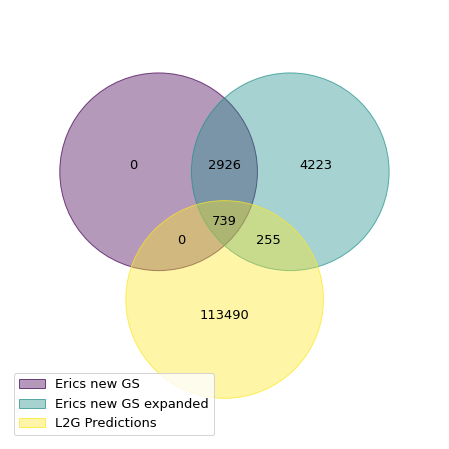

In [190]:
l2g_predictions = set(l2g_table_processed_w_trait.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())
new_gs = set(eric_gs.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())
new_gs_expanded = set(eric_gs_expanded.withColumn("assoc", F.concat('gene_id',F.lit('/'), 'trait_id')).select('assoc').toPandas()['assoc'].to_list())

venn_sets = {
    'Erics new GS': new_gs,
    'Erics new GS expanded': new_gs_expanded,
    'L2G Predictions': l2g_predictions,
}

venn(venn_sets, legend_loc="best")

In [195]:
test = l2g_table_processed_w_trait.withColumn('num', F.lit(5)).toPandas().head()

test

,variant_id,gene_id,max_proba,trait_id,num
0,10_100006605_T_C,ENSG00000107554,0.823078,EFO_0004570,5
1,10_100050547_C_T,ENSG00000120054,0.833693,EFO_0004747,5
2,10_102511024_G_A,ENSG00000148842,0.326732,EFO_0007988,5
3,10_103199143_G_A,ENSG00000148842,0.358590,EFO_0006335,5
4,10_103565017_C_T,ENSG00000107954,0.856294,EFO_0000275,5


In [29]:
# FURTHER TASKS:

- EXPORT DATASET OF INTERSECTION BETWEEN NEW GS AND L2G GS
- EXTRACT THE OVERLAP PER TYPE OF CURATION OF THE L2G GS IN THE NEW GS

SyntaxError: invalid syntax (<ipython-input-29-8a5aa9cd0778>, line 3)